### 1. Library

In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

# 데이터 전처리에 필요한 라이브러리
from sklearn.preprocessing import MinMaxScaler

# 모델에 필요한 라이브러리
from keras import models
from keras import layers
from keras  import regularizers
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

### 2. Data Loading

In [2]:
# SET1 데이터 : 2018년 2월 ~ 2019년 2월
# 환율 미국 달러 가격만 표시되어 있음.
set1 = pd.read_csv('../data/set01.csv')
set1 = set1.set_index('Date')

In [3]:
set1

,Rate
Date,
2018-02-01,1069.6
2018-02-02,1072.5
2018-02-05,1076.7
2018-02-06,1089.8
2018-02-07,1094.3
...,...
2019-02-22,1124.4
2019-02-25,1125.7
2019-02-26,1120.8


### 3. Shift Data

In [4]:
# 과거 날짜 지정
past_days = 5

# 최근 5일까지의 과거 데이터를 생성
for step in range(1,past_days+1):
    set1['shift_{}'.format(step)] = set1['Rate'].shift(step)

In [5]:
set1

,Rate,shift_1,shift_2,shift_3,shift_4,shift_5
Date,,,,,,
2018-02-01,1069.6,NaN,NaN,NaN,NaN,NaN
2018-02-02,1072.5,1069.6,NaN,NaN,NaN,NaN
2018-02-05,1076.7,1072.5,1069.6,NaN,NaN,NaN
2018-02-06,1089.8,1076.7,1072.5,1069.6,NaN,NaN
2018-02-07,1094.3,1089.8,1076.7,1072.5,1069.6,NaN
...,...,...,...,...,...,...
2019-02-22,1124.4,1122.6,1127.5,1124.7,1127.7,1125.0
2019-02-25,1125.7,1124.4,1122.6,1127.5,1124.7,1127.7
2019-02-26,1120.8,1125.7,1124.4,1122.6,1127.5,1124.7


### 4. 결측값 제거

In [6]:
# 앞의 5일은 과거데이터가 없으므로 결측값으로 판단하고 행 제거.
set1 = set1.dropna()
set1

,Rate,shift_1,shift_2,shift_3,shift_4,shift_5
Date,,,,,,
2018-02-08,1083.3,1094.3,1089.8,1076.7,1072.5,1069.6
2018-02-09,1087.8,1083.3,1094.3,1089.8,1076.7,1072.5
2018-02-12,1092.7,1087.8,1083.3,1094.3,1089.8,1076.7
2018-02-13,1083.4,1092.7,1087.8,1083.3,1094.3,1089.8
2018-02-14,1082.8,1083.4,1092.7,1087.8,1083.3,1094.3
...,...,...,...,...,...,...
2019-02-22,1124.4,1122.6,1127.5,1124.7,1127.7,1125.0
2019-02-25,1125.7,1124.4,1122.6,1127.5,1124.7,1127.7
2019-02-26,1120.8,1125.7,1124.4,1122.6,1127.5,1124.7


### 5. Shift 순서 뒤집기

In [7]:
set1 = set1[['Rate', 'shift_5', 'shift_4', 'shift_3', 'shift_2', 'shift_1']]
set1

,Rate,shift_5,shift_4,shift_3,shift_2,shift_1
Date,,,,,,
2018-02-08,1083.3,1069.6,1072.5,1076.7,1089.8,1094.3
2018-02-09,1087.8,1072.5,1076.7,1089.8,1094.3,1083.3
2018-02-12,1092.7,1076.7,1089.8,1094.3,1083.3,1087.8
2018-02-13,1083.4,1089.8,1094.3,1083.3,1087.8,1092.7
2018-02-14,1082.8,1094.3,1083.3,1087.8,1092.7,1083.4
...,...,...,...,...,...,...
2019-02-22,1124.4,1125.0,1127.7,1124.7,1127.5,1122.6
2019-02-25,1125.7,1127.7,1124.7,1127.5,1122.6,1124.4
2019-02-26,1120.8,1124.7,1127.5,1122.6,1124.4,1125.7


### 4. Train Valid Test Split

In [8]:
# 2018년 2월 ~ 2019년 1월을 Train, 2019년 2월을 Test.
# USD를 Target, 나머지 Shift를 Input으로 지정.

# Train Data
train_data = set1[:'2019-01-31'][set1.columns[1:]]
train_targets = set1[:'2019-01-31'][set1.columns[0]]

# Test Data
test_data = set1['2019-02-01':][set1.columns[1:]]
test_targets = set1['2019-02-01':][set1.columns[0]]

# Reshape to Numpy Array : 4개의 데이터프레임을 모두 Numpy 배열로 변경.
train_data = np.array(train_data)
train_targets = np.array(train_targets)
test_data = np.array(test_data)
test_targets = np.array(test_targets)

In [9]:
train_data.shape

(240, 5)

In [10]:
test_data.shape

(17, 5)

In [11]:
train_targets

array([1083.3, 1087.8, 1092.7, 1083.4, 1082.8, 1079.9, 1068. , 1070.3,
       1075.3, 1082.9, 1078.5, 1073.7, 1071. , 1081.9, 1081.3, 1080.5,
       1075.4, 1068.7, 1068.4, 1069.2, 1064.3, 1065.8, 1065.8, 1065.8,
       1069.6, 1071.2, 1071. , 1071.4, 1069.2, 1080.8, 1081.2, 1072.2,
       1069.4, 1066.5, 1064.4, 1058.1, 1057.8, 1057.6, 1059.5, 1066. ,
       1067.5, 1067.7, 1066.4, 1068.7, 1070. , 1073.1, 1068.4, 1066.5,
       1063.5, 1067.3, 1068.9, 1076.9, 1078.7, 1079.7, 1076.2, 1067.5,
       1074.9, 1076.5, 1076.7, 1078.2, 1081.3, 1075.3, 1068.6, 1066.6,
       1072.6, 1078.7, 1079.3, 1080. , 1083.8, 1078.8, 1079.7, 1078.7,
       1073.2, 1076.1, 1081.3, 1076.4, 1076. , 1070.9, 1069.6, 1067.9,
       1073.2, 1073.5, 1075.1, 1082.5, 1091.4, 1104.4, 1105.5, 1108. ,
       1109. , 1108.9, 1116.1, 1115.2, 1117.9, 1121.7, 1117.2, 1117.4,
       1121.1, 1115.3, 1118.4, 1117.8, 1112.3, 1113.8, 1120.8, 1127.8,
       1123.4, 1128.7, 1125.2, 1128.9, 1131.2, 1134.8, 1128.5, 1135.2,
      

In [12]:
test_targets

array([1111.6, 1116.8, 1123.4, 1124.5, 1124.5, 1124.6, 1121.7, 1125. ,
       1127.7, 1124.7, 1127.5, 1122.6, 1124.4, 1125.7, 1120.8, 1118.3,
       1117.8])

### 5. 데이터 정규화

In [13]:
# Input에 대해서만 정규화 진행.
# 평균이 0, 표준편차가 1인 정규분포로 데이터를 변경.
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

# 과적합을 막기위해서 Train의 정보를 이용하여, Test에 적용한다.
test_data -= mean
test_data /= std

### 6. Model Build

In [14]:
# 데이터의 개수가 그렇게 많지 않으므로, 모델을 깊게 생성하지는 않는다.
def build_model():
    model = models.Sequential()
    
    # 1st Layer
    model.add(layers.Dense(1000, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                           activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dropout(0.5))
    # 2nd Layer
    model.add(layers.Dense(1000, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation='relu'))
    model.add(layers.Dropout(0.5))
    # Result
    model.add(layers.Dense(1))
    # Model Compile
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

### 9. Test 예측

In [15]:
# 새롭게 컴파인된 모델을 얻습니다.
model = build_model()

# 시간측정 시작
start = timeit.default_timer()

# 전체 데이터로 훈련시킵니다.
model.fit(train_data, train_targets, epochs=1000, batch_size=200, verbose=1)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

# 시간측정 종료
stop = timeit.default_timer()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Epoch 1/1000
240/240 [==============================] - 4s 16ms/step - loss: 1222236.3750 - mean_absolute_error: 1105.2465
Epoch 2/1000
240/240 [==============================] - 0s 47us/step - loss: 1207450.0833 - mean_absolute_error: 1098.5019
Epoch 3/1000
240/240 [==============================] - 0s 44us/step - loss: 1184565.4375 - mean_absolute_error: 1087.9730
Epoch 4/1000
240/240 [==============================] - 0s 49us/step - loss: 1154906.6667 - mean_absolute_error: 1074.1505
Epoch 5/1000
240/240 [==============================] - 0s 46us/step - loss: 1117929.4375 - mean_absolute_error: 1056.6571
Epoch 6/1000
240/240 [==============================] - 0s 45us/step - loss: 1078105.9583 - mean_absolute_error: 1037.4641
Epoch 7/1000
240/240 [==============================] - 0s 49us/step - loss: 1032048.2500 - mean_absolute_error: 1014.7164
Epoch 8/1000
240/2

In [16]:
# Test 점수
print('test_mae_score = {}' .format(test_mae_score))

test_mae_score = 3.057401657104492


In [17]:
# 모델 진행 시간
print('진행 시간 : {:.2f}초' .format(stop - start))

진행 시간 : 18.47초


### 10. 1일뒤 예측 결과

In [18]:
result = pd.DataFrame()
result['Date'] = set1['2019-02-01':].index
result['DNN_Model'] = model.predict(test_data).reshape(-1)
result['Actual'] = test_targets
result['Error'] = result['Actual'] - result['DNN_Model']
result = result.set_index('Date')
result

,DNN_Model,Actual,Error
Date,,,
2019-02-01,1118.211670,1111.6,-6.611670
2019-02-07,1111.653320,1116.8,5.146680
2019-02-08,1116.208374,1123.4,7.191626
2019-02-11,1123.924683,1124.5,0.575317
2019-02-12,1125.120361,1124.5,-0.620361
2019-02-13,1124.049072,1124.6,0.550928
2019-02-14,1124.782593,1121.7,-3.082593
2019-02-15,1122.508179,1125.0,2.491821
2019-02-18,1126.383301,1127.7,1.316699


In [19]:
# 상승, 하락의 방향성만....!
result[['DNN_Model', 'Actual']].corr()

,DNN_Model,Actual
DNN_Model,1.00000,0.61208
Actual,0.61208,1.00000


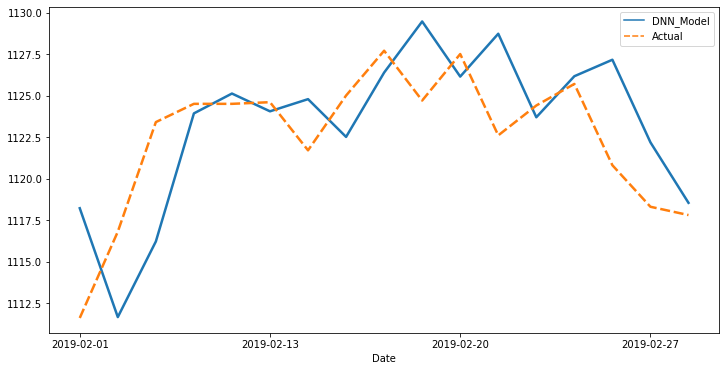

In [20]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=result[result.columns[:-1]], palette="tab10", linewidth=2.5)
ax.set(xticks = result.index[0::5])
plt.show()

### 11. Virtual Data를 생성하여 5일까지 예측

In [21]:
set1['2019-02-01':'2019-02-26'][['Rate']]

,Rate
Date,
2019-02-01,1111.6
2019-02-07,1116.8
2019-02-08,1123.4
2019-02-11,1124.5
2019-02-12,1124.5
2019-02-13,1124.6
2019-02-14,1121.7
2019-02-15,1125.0
2019-02-18,1127.7


In [22]:
# Test에 사용할 데이터
test = pd.read_csv('../data/set01.csv')
test = test.set_index('Date')
test = test['2019-01-25' : '2019-01-31']

# 1일 뒤 예측
test_sc = (np.array(test[-5:].T) - mean) / std
pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['1일뒤'])
test = test.append(pred_df)

# 2일 뒤 예측
test_sc = (np.array(test[-5:].T) - mean) / std
pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['2일뒤'])
test = test.append(pred_df)

# 3일 뒤 예측
test_sc = (np.array(test[-5:].T) - mean) / std
pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['3일뒤'])
test = test.append(pred_df)

# 4일 뒤 예측
test_sc = (np.array(test[-5:].T) - mean) / std
pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['4일뒤'])
test = test.append(pred_df)

# 5일 뒤 예측
test_sc = (np.array(test[-5:].T) - mean) / std
pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['5일뒤'])
test = test.append(pred_df)

# 결과
test

,Rate
2019-01-25,1128.000000
2019-01-28,1125.100000
2019-01-29,1116.900000
2019-01-30,1118.100000
2019-01-31,1117.200000
1일뒤,1118.211792
2일뒤,1119.094849
3일뒤,1118.807983
4일뒤,1118.682861
5일뒤,1118.366455


In [23]:
# Test에 사용할 데이터
test = pd.read_csv('../data/set01.csv')
test = test.set_index('Date')
test = test['2019-02-01' : '2019-02-12']

# 1일 뒤 예측
test_sc = (np.array(test[-5:].T) - mean) / std
pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['1일뒤'])
test = test.append(pred_df)

# 2일 뒤 예측
test_sc = (np.array(test[-5:].T) - mean) / std
pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['2일뒤'])
test = test.append(pred_df)

# 3일 뒤 예측
test_sc = (np.array(test[-5:].T) - mean) / std
pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['3일뒤'])
test = test.append(pred_df)

# 4일 뒤 예측
test_sc = (np.array(test[-5:].T) - mean) / std
pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['4일뒤'])
test = test.append(pred_df)

# 5일 뒤 예측
test_sc = (np.array(test[-5:].T) - mean) / std
pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['5일뒤'])
test = test.append(pred_df)

# 결과
test

,Rate
2019-02-01,1111.600000
2019-02-07,1116.800000
2019-02-08,1123.400000
2019-02-11,1124.500000
2019-02-12,1124.500000
1일뒤,1124.049072
2일뒤,1124.162354
3일뒤,1125.278198
4일뒤,1126.709229
5일뒤,1128.332764


In [24]:
# Test에 사용할 데이터
test = pd.read_csv('../data/set01.csv')
test = test.set_index('Date')
test = test['2019-02-13' : '2019-02-19']

# 1일 뒤 예측
test_sc = (np.array(test[-5:].T) - mean) / std
pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['1일뒤'])
test = test.append(pred_df)

# 2일 뒤 예측
test_sc = (np.array(test[-5:].T) - mean) / std
pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['2일뒤'])
test = test.append(pred_df)

# 3일 뒤 예측
test_sc = (np.array(test[-5:].T) - mean) / std
pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['3일뒤'])
test = test.append(pred_df)

# 4일 뒤 예측
test_sc = (np.array(test[-5:].T) - mean) / std
pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['4일뒤'])
test = test.append(pred_df)

# 5일 뒤 예측
test_sc = (np.array(test[-5:].T) - mean) / std
pred_df = pd.DataFrame({'Rate':model.predict(test_sc).reshape(-1)[0]}, index=['5일뒤'])
test = test.append(pred_df)

# 결과
test

,Rate
2019-02-13,1124.600000
2019-02-14,1121.700000
2019-02-15,1125.000000
2019-02-18,1127.700000
2019-02-19,1124.700000
1일뒤,1126.142334
2일뒤,1127.195190
3일뒤,1128.859741
4일뒤,1131.210938
5일뒤,1133.349731


In [25]:
# 모델이 추천하는 매입 시점
point = ['2019-02-12', '2019-02-19', '2019-02-26']
model_pred = np.sum(set1.loc[point]['Rate']) * 5
print('모델이 추천한 날짜마다 5달러씩 매입시 가격 : {}원' .format(model_pred))

모델이 추천한 날짜마다 5달러씩 매입시 가격 : 16850.0원


In [26]:
# 매일 1달러씩 15일간 15달러 매입
real = np.sum(set1['2019-02-01':'2019-02-26'][['Rate']]).values[0]
print('매일 1달러씩 매입시 가격 : {}원' .format(real))

매일 1달러씩 매입시 가격 : 16845.5원


In [31]:
print('손익 계산 : {}원 이익!!!!!, 약 {:.5f}%의 이익률' .format(real - model_pred, (real - model_pred)/real))

손익 계산 : -4.5원 이익!!!!!, 약 -0.00027%의 이익률


### 결론

 - **단순 등락여부를 맞춘다고 가정했을 때는 60% 정도의 예측 정확도를 보임.**
 
 
 - **DNN을 사용한 결과 시퀀스의 특징을 완전히 무시함. --> 값은 예측이 되는 것처럼 보이지만, 항상 5일 뒤가 가장 낮은 값을 보임.**
 
 
 - **RNN, LSTM과의 비교가 필요함.**
 
 
 - **한번에 5일까지를 예측하는 가장 좋은 방법이 뭘까....?**